# Imports

We will use some Huggingface libraries for downloading and processing the dataset, and therefore need to install them first.\
The first is the datasets library which allows you to download and manipulate datasets.\
See [their guide](https://huggingface.co/docs/datasets/installation) for an introduction to the datasets library if you want to know more.\
The other library helps us in downloading data from the Huggingface Hub.

We can simple install them using pip:
> Note that `%pip` is a magic command for use in Jupyter Notebooks as discussed in the tutorial on setting up Python!

In [ ]:
%pip install datasets huggingface_hub ipywidgets

In [ ]:
import zipfile
from functools import partial

import matplotlib.pyplot as plt
import torch
from datasets import load_dataset
from huggingface_hub import hf_hub_download
from torch.utils.data import DataLoader
from tqdm.auto import trange

# Sentiment Analysis

Sentiment Analysis (SA) determines the emotional tone of a text sequence (e.g., a sentence) and classifies it into predefined categories.\
Therefore, SA is a text classification task which assigns a single class to the whole input.

In this part, we will use the SST2 dataset, which stands for Stanford Sentiment Treebank.\
This is a binary task where inputs are labeled as `positive` (`1`) or `negative` (`0`).

There are several possibilites on how to 'solve' this task.\
Starting from sequences, there exist many ways to turn them into features.\
A common way is to split them into smaller units, called tokens, which could be words.\
For this, there are again many possibilities how this can be implemented.\
You can do it manually or use some library for it, and there are many NLP libraries.\
Also, the neural network architecture can be almost arbitrary.

## Dataset Loading

There are several possibiliites for downloading datasets.\
You can read them from files, or directly use a library with an online repository of datasets, such as [Huggingface Datasets](https://huggingface.co/docs/datasets/index).

> A note on the Huggingface Datasets library: You can decide where downloaded files are cached, see https://huggingface.co/docs/datasets/v3.2.0/en/cache#cache-directory.\
> The documentation is as always a good source of information!

We will use this library in our example:

In [ ]:
sst2 = load_dataset("stanfordnlp/sst2")
# Print the dataset object to see the dataset's structure
print(sst2)

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})


If you want to learn more about using this library, there is a very useful [tutorial](https://huggingface.co/docs/datasets/v3.2.0/en/tutorial) available online.

We see that there are three splits, and how many samples are contained in each split.\
Let's take a look at an example.

In [ ]:
dataset_train = sst2["train"]
# Print the first sample in the training dataset
print(dataset_train[0])

{'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0}


As we can see, each sample includes an index, the input sentence and a label.\
This sample was labeled `negative` (`0`; `1` stand for `positive` in this dataset).

## Embeddings

In order to turn words into features, we can use pre-trained embeddings.\
These have been trained to carry the semantics of the words.

### GloVe
In GloVe, differences of word pairs should be roughly equal:\
<img src="https://nlp.stanford.edu/projects/glove/images/man_woman.jpg" width=500/>\
Source: https://nlp.stanford.edu/projects/glove/

GloVe embeddings exist trained on different data (varying in the number of tokens and vocabulary size), and with different embedding dimension:

In [ ]:
# Download the GloVe embeddings
glove = hf_hub_download("stanfordnlp/glove", "glove.6B.zip")

with zipfile.ZipFile(glove, "r") as f:
    print(f.namelist())

['glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt', 'glove.6B.50d.txt']


In this tutorial, we use the smallest vocabulary size with 300-dimensional features (but feel free to experiment with other dimensions!).\
How does the file look like?

In [ ]:
# There are multiple files with different dimensionality of the features in the zip archive: 50d, 100d, 200d, 300d
filename = "glove.6B.300d.txt"
with zipfile.ZipFile(glove, "r") as f:
    for idx, line in enumerate(f.open(filename)):
        print(line)
        if idx == 5:
            break

b'the 0.04656 0.21318 -0.0074364 -0.45854 -0.035639 0.23643 -0.28836 0.21521 -0.13486 -1.6413 -0.26091 0.032434 0.056621 -0.043296 -0.021672 0.22476 -0.075129 -0.067018 -0.14247 0.038825 -0.18951 0.29977 0.39305 0.17887 -0.17343 -0.21178 0.23617 -0.063681 -0.42318 -0.11661 0.093754 0.17296 -0.33073 0.49112 -0.68995 -0.092462 0.24742 -0.17991 0.097908 0.083118 0.15299 -0.27276 -0.038934 0.54453 0.53737 0.29105 -0.0073514 0.04788 -0.4076 -0.026759 0.17919 0.010977 -0.10963 -0.26395 0.07399 0.26236 -0.1508 0.34623 0.25758 0.11971 -0.037135 -0.071593 0.43898 -0.040764 0.016425 -0.4464 0.17197 0.046246 0.058639 0.041499 0.53948 0.52495 0.11361 -0.048315 -0.36385 0.18704 0.092761 -0.11129 -0.42085 0.13992 -0.39338 -0.067945 0.12188 0.16707 0.075169 -0.015529 -0.19499 0.19638 0.053194 0.2517 -0.34845 -0.10638 -0.34692 -0.19024 -0.2004 0.12154 -0.29208 0.023353 -0.11618 -0.35768 0.062304 0.35884 0.02906 0.0073005 0.0049482 -0.15048 -0.12313 0.19337 0.12173 0.44503 0.25147 0.10781 -0.17716 0.03

In [ ]:
# Unpack the downloaded file
word_to_index = dict()
embeddings = []

with zipfile.ZipFile(glove, "r") as f:
    for idx, line in enumerate(f.open(filename)):
        values = line.split()
        word = values[0].decode("utf-8")
        features = torch.tensor([float(value) for value in values[1:]])
        word_to_index[word] = idx
        embeddings.append(features)

### Task
Play around and inspect the dataset!

In [ ]:
print(f"Number of words in the vocabulary: {len(word_to_index)}")
print(f"Embedding dimensionality: {embeddings[0].shape[0]}")

# Create a reverse mapping from index to word to easily retrieve words from their indices (the line numbers in the file)
index_to_word = {idx: word for word, idx in word_to_index.items()}

print(f"First word in the vocabulary: {index_to_word[0]}")
print(f"Last word in the vocabulary: {index_to_word[len(index_to_word) - 1]}")

Number of words in the vocabulary: 400001
Embedding dimensionality: 300
First word in the vocabulary: the
Last word in the vocabulary: <unk>


We bring the embeddings into a useful format:

In [ ]:
# Last token in the vocabulary is '<unk>' which is used for out-of-vocabulary words
# We also add a '<pad>' token to the vocabulary for padding sequences
word_to_index["<pad>"] = len(word_to_index)
padding_token_id = word_to_index["<pad>"]
unk_token_id = word_to_index["<unk>"]

embeddings.append(torch.zeros(embeddings[0].shape))

# Convert the list of tensors to a single tensor
embeddings = torch.stack(embeddings)

print(f"Embedding shape: {embeddings.size(1)}")
print(f"Padding token id: {padding_token_id}")
print(f"Unknown token id: {unk_token_id}")

Embedding shape: 300
Padding token id: 400001
Unknown token id: 400000


## Data Processing

Starting from our input sentences, we need to 1) tokenize the sentences to get smaller units (words or tokens) and 2) convert these tokens into vector representations using the pre-trained embeddings.

The datasets library provides support for processing datasets, for more information see https://huggingface.co/docs/datasets/process.


In [ ]:
def tokenize(text: str):
    # We lowercase the text and split it by whitespaces to extract the tokens
    # Punctuation is treated as separate tokens
    return text.lower().split()


def map_token_to_index(token):
    # Return the index of the token or the index of the '<unk>' token if the token is not in the vocabulary
    return word_to_index.get(token, unk_token_id)


def map_text_to_indices(text: str):
    return [map_token_to_index(token) for token in tokenize(text)]


def prepare_dataset(dataset):
    return dataset.map(lambda x: {"token_ids": map_text_to_indices(x["sentence"])}, num_proc=4)


dataset_train_tokenized = prepare_dataset(dataset_train)

# Print the first sample in the tokenized training dataset
print(dataset_train_tokenized[0])

{'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0, 'token_ids': [5708, 50, 52776, 25, 0, 13054, 1503]}


Next, we need a dataloader that takes care of batching our data.\
You have seen this before, but this time we need also take care of padding, since the length of the sentences varies in our dataset.

In [ ]:
def pad_inputs(batch, keys_to_pad=["token_ids"], padding_value=-1):
    # Pad keys_to_pad to the maximum length in batch
    padded_batch = {}
    for key in keys_to_pad:
        # Get maximum length in batch
        max_len = max([len(sample[key]) for sample in batch])
        # Pad all samples to the maximum length
        padded_batch[key] = torch.tensor(
            [
                sample[key] + [padding_value] * (max_len - len(sample[key]))
                for sample in batch
            ]
        )
    # Add remaining keys to the batch
    for key in batch[0].keys():
        if key not in keys_to_pad:
            padded_batch[key] = torch.tensor([sample[key] for sample in batch])
    return padded_batch


def get_dataloader(dataset, batch_size=32, shuffle=False):
    # Create a DataLoader for the dataset
    return DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=partial(pad_inputs, padding_value=padding_token_id),
        shuffle=shuffle,
    )


# We select the columns that we want to keep in the dataset
dataset_train_tokenized = dataset_train_tokenized.with_format(
    columns=["token_ids", "label"]
)
# Create a DataLoader for the training dataset
dataloader_train = get_dataloader(dataset_train_tokenized, batch_size=8, shuffle=True)

for batch in dataloader_train:
    token_ids = batch["token_ids"]
    labels = batch["label"]
    print(token_ids)
    print(labels)
    break

tensor([[  5613,     14,     24,    862,    135,     22,    392,   1716,      5,
          11082,   1703,  10602,     14,     70,    151,   8352,    131,      2],
        [    26,   6422,     17,  29724,     14,    191,  27886, 400001, 400001,
         400001, 400001, 400001, 400001, 400001, 400001, 400001, 400001, 400001],
        [     7,  11497,      9,   2408, 400001, 400001, 400001, 400001, 400001,
         400001, 400001, 400001, 400001, 400001, 400001, 400001, 400001, 400001],
        [    14,      0,   5230,      9,   9830,   2728,      3,  50929, 400000,
           1739,   8735, 400001, 400001, 400001, 400001, 400001, 400001, 400001],
        [    41,     33,      4,   6338,     12,     41,    913,  24646,     21,
           3745,  21946, 400001, 400001, 400001, 400001, 400001, 400001, 400001],
        [   596,   8833,      9,  50507,   2054,      3,    732,      4,     30,
          28350, 400001, 400001, 400001, 400001, 400001, 400001, 400001, 400001],
        [    20,      

## Model
We will use a simple network here with the pre-trained embeddings.

In [ ]:
class SimpleTextClassifier(torch.nn.Module):
    def __init__(self, embeddings, hidden_size=128, padding_index=-1):
        super().__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(
            embeddings, freeze=True, padding_idx=padding_index
        )
        self.layer1 = torch.nn.Linear(embeddings.shape[1], hidden_size)
        self.output_layer = torch.nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.embedding(x)
        # x is of dimension (batch_size, seq_len, embedding_dim)
        # By summing the embeddings of all tokens in the sequence, we get a bag-of-words vector for each sample input
        x = torch.sum(x, dim=1)
        x = torch.relu(self.layer1(x))
        x = self.output_layer(x)
        return x

We instantiate and verify that the model is working (no errors):

In [ ]:
model = SimpleTextClassifier(embeddings, padding_index=padding_token_id)
print(model(torch.tensor(dataset_train_tokenized["token_ids"][:2])))

tensor([[ 0.0066,  0.2412],
        [-0.2169,  0.3593]], grad_fn=<AddmmBackward0>)


### Task
How would you use an RNN instead of this simple feed-forward network?\
See https://pytorch.org/docs/stable/nn.html#recurrent-layers for details on how to use RNNs in PyTorch.

![RNN for Sentence Classification](https://www.tensorflow.org/static/text/tutorials/images/bidirectional.png)\
Source: https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [ ]:
class RNNTextClassifier(torch.nn.Module):
    def __init__(
        self,
        embeddings,
        hidden_size=128,
        padding_index=-1,
        num_layers=1,
        bidirectional=True,
    ):
        super().__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(
            embeddings, freeze=True, padding_idx=padding_index
        )
        self.rnn = torch.nn.RNN(
            embeddings.shape[1],
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
        )
        self.output_layer = torch.nn.Linear(
            num_layers * (int(bidirectional) + 1) * hidden_size, 2
        )

    def forward(self, x):
        x = self.embedding(x)
        all_hidden_states, last_hidden_state = self.rnn(x)
        # Concatenate the hidden states of all layers and directions
        hidden_state = torch.cat(list(last_hidden_state), dim=-1)
        # hidden_state = torch.cat([tensor for tensor in last_hidden_state], dim=-1)
        output = self.output_layer(hidden_state)
        return output

In [ ]:
model = RNNTextClassifier(embeddings, padding_index=padding_token_id)
print(model(torch.tensor(dataset_train_tokenized["token_ids"][0])))

tensor([-0.3772, -0.0743], grad_fn=<ViewBackward0>)


## Evaluation

To assess the performance of our model, we compute a metric that fits for our task.\
For pure classification like SA, this is often the accuracy and optionally also the loss on the provided dataset:

In [ ]:
def compute_accuracy(predictions: torch.tensor, labels: torch.tensor):
    return torch.sum(torch.argmax(predictions, dim=1) == labels).item() / len(labels)


def evaluate_model(model, dataset, loss_fn=None):
    # Compute the accuracy and optionally the loss of the model on the dataset
    dataloader = get_dataloader(dataset, batch_size=32)
    accuracies = []
    losses = []
    # We don't need to compute gradients for the evaluation
    with torch.no_grad():
        for batch in dataloader:
            token_ids = batch["token_ids"]
            labels = batch["label"]
            predictions = model(token_ids)
            if loss_fn:
                loss = loss_fn(predictions, labels)
                losses.append(loss.item())
            accuracies.append(compute_accuracy(predictions, labels))
    return sum(accuracies) / len(accuracies), (
        (sum(losses) / len(losses)) if loss_fn else None
    )

Since we want to evaluate our model on a separate dataset, we will also have to process this similarly to our training data:

In [ ]:
dataset_val = sst2["validation"]
dataset_val_tokenized = prepare_dataset(dataset_val)
dataset_val_tokenized = dataset_val_tokenized.with_format(
    columns=["token_ids", "label"]
)

Now we can evaluate our model:

In [ ]:
accuracy, _ = evaluate_model(model, dataset_val_tokenized)
print(f"Accuracy on the validation dataset: {accuracy}")

Accuracy on the validation dataset: 0.49330357142857145


With randomly initialized weights, we expect to end up at ~50% Accuracy (in average)!

## Training

Now having processed the data and instantiated our model, it is time for training.\
Therefore, we need a loss function and an optimizer.\
The rest is just a simple training loop as before.

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
losses_train, losses_val = [], []
accuracies_train, accuracies_val = [], []

# Compute loss and accuracy on the training set
accuracy, loss = evaluate_model(model, dataset_train_tokenized, loss_fn)
losses_train.append(loss)
accuracies_train.append(accuracy)

# Compute loss and accuracy on the validation set
accuracy, loss = evaluate_model(model, dataset_val_tokenized, loss_fn)
losses_val.append(loss)
accuracies_val.append(accuracy)

NUM_EPOCHS = 10

# A progress bar to visualize the training progress
pbar = trange(NUM_EPOCHS)
# Training loop
for epoch in pbar:
    # Do one epoch of training
    for batch in dataloader_train:
        # Extract the token ids and the labels from the batch
        token_ids = batch["token_ids"]
        labels = batch["label"]

        # Forward pass
        predictions = model(token_ids)
        loss = loss_fn(predictions, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate the loss and accuracy on the training set
    acc_train, loss_train = evaluate_model(model, dataset_train_tokenized, loss_fn)
    accuracies_train.append(acc_train)
    losses_train.append(loss_train)

    # Evaluate the model on the validation set
    acc_val, loss_val = evaluate_model(model, dataset_val_tokenized, loss_fn)
    accuracies_val.append(acc_val)
    losses_val.append(loss_val)

    pbar.set_postfix_str(
        f"Train loss: {losses_train[-1]} - Validation acc: {accuracies_val[-1]}"
    ) 

  0%|          | 0/10 [00:00<?, ?it/s]

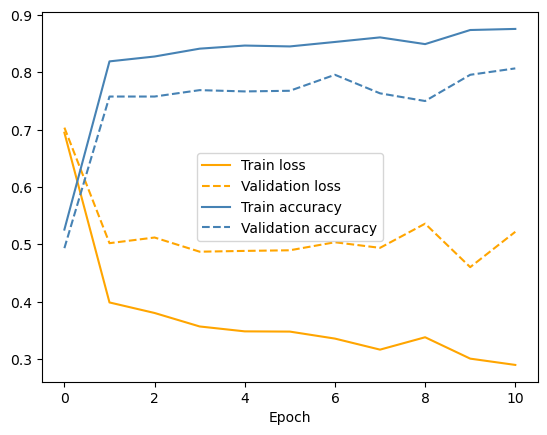

In [ ]:
# Visualize the loss and accuracy
plt.plot(losses_train, color="orange", linestyle="-", label="Train loss")
plt.plot(losses_val, color="orange", linestyle="--", label="Validation loss")
plt.plot(accuracies_train, color="steelblue", linestyle="-", label="Train accuracy")
plt.plot(accuracies_val, color="steelblue", linestyle="--", label="Validation accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## Interactive Prediction

We'd like to perform some interactive testing with our trained model.\
Widgets allow for a simple text interface:

In [ ]:
from ipywidgets import widgets
from IPython.display import display

sentence_widget = widgets.Text(
    value="This movie is terrible",
    placeholder="Type something",
    description="Sentence:",
    disabled=False,
)
display(sentence_widget)

Text(value='This movie is terrible', description='Sentence:', placeholder='Type something')

### Task

Now the task is to do a prediction for the provided sentence using our trained model.

Some hints:
* You need to convert the input sentence to token ids, using the same mapping as for training. Can you re-use something to accomplish this?
* Since we only have a single input, we don't need batching nor a dataloader
* We don't need the gradients from the model

In [ ]:
sentence = sentence_widget.value

token_ids = torch.tensor([map_text_to_indices(sentence)])
with torch.no_grad():
    predictions = model(token_ids)
predicted_class = torch.argmax(predictions).item()
print(f"The predicted class for the sentence '{sentence}' is: {'positive' if predicted_class == 1 else 'negative'}")

The predicted class for the sentence 'This movie is terrible' is: negative
